# Title

**Exercise 1 - Dealing with Missingness**

# Description

The goal of the exercise is to get comfortable with missingness, and how to handle it and do some basic imputations in skealrn.  Firday's class will go further into handling missngness.

# Instructions: 
We are using synthetic data to illustrate the issues with missing data.  We will
- Create a synthetic dataset from two predictors
- Create missingness in 3 different ways
- Handle it 4 different wats (dropping rows, mean imputation, OLS imputation, and 3-NN imputation)

# Hits:

<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html" target="_blank">pandas.dropna</a> : Drop rows with missingness

<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html" target="_blank">pandas.fillna</a> : Fill in missingness

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html" target="_blank">sklearn.LinearRegression</a> : Generates a Linear Regression Model

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html" target="_blank">sklearn.KNNImputer</a> : Fill in missingness

**Note: This exercise is auto-graded and you can try multiple attempts.**

In [1]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator

# Dealing with Missingness

## Missing Data
Create data in which the true theoretical regression line is:
$$ Y = 3X_1 + 2X_2 + \varepsilon,\hspace{0.1in} \varepsilon \sim N(0,1)$$

Note: $\rho_{X1,X2} = 0.5$

We will be inserting missingness into `x1` in various ways, and analyzing the results.

In [3]:
n = 500
np.random.seed(109)

x1 = np.random.normal(0,1,size=n)
x2 = 0.5*x1+np.random.normal(0,np.sqrt(0.75),size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])

y = 3*x1 - 2*x2 + np.random.normal(0,1,size=n)
y = pd.Series(y)


df = pd.DataFrame(data=np.transpose([x1,x2,y]),columns=["x1","x2","y"])

# Checking the correlation
scipy.stats.pearsonr(x1,x2) 

PearsonRResult(statistic=0.5271942804503282, pvalue=4.117031329303493e-37)

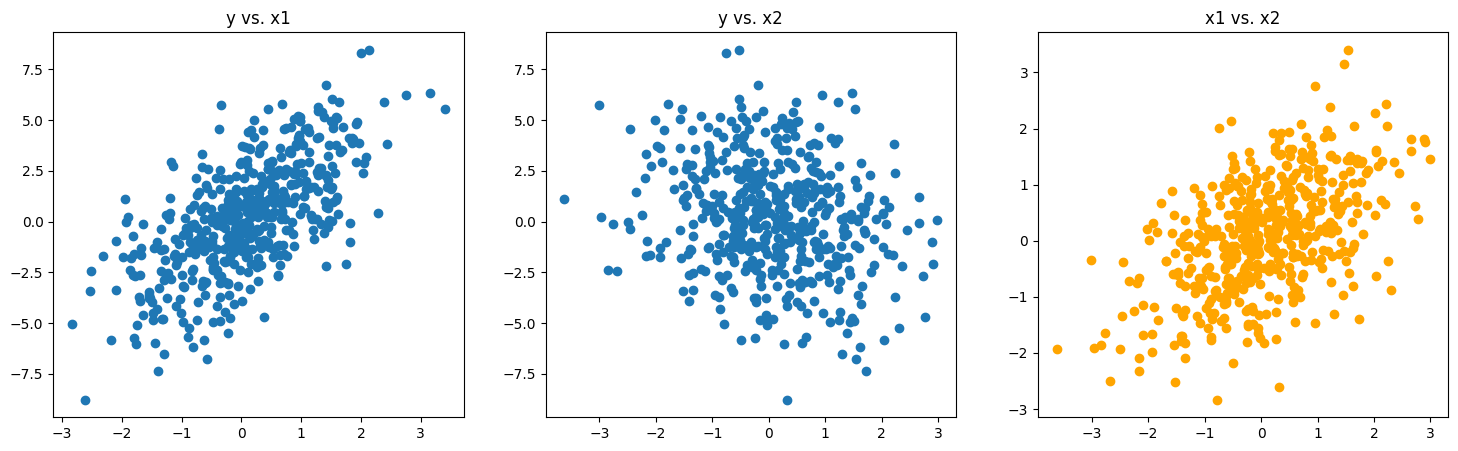

In [4]:
fig,(ax1,ax2,ax3) =  plt.subplots(1, 3, figsize = (18,5))
ax1.scatter(x1,y)
ax2.scatter(x2,y)
ax3.scatter(x2,x1,color="orange")
ax1.set_title("y vs. x1")
ax2.set_title("y vs. x2")
ax3.set_title("x1 vs. x2")
plt.show()

### Poke holes in $X_1$ in 3 different ways (all roughly 20% of data are removed): 

- MCAR: just take out a random sample of 20% of observations in $X_1$
- MAR: missingness in  $X_1$ depends on $X_2$, and thus can be recovered in some way
- MNAR: missingness in  $X_1$ depends on $X_1$, and thus can be recovered in some way


In [5]:
x1_mcar = x1.copy()
x1_mar = x1.copy()
x1_mnar = x1.copy()

#missing completely at random
miss_mcar = np.random.choice(n,int(0.2*n),replace=False)
x1_mcar[miss_mcar] = np.nan

#missing at random: one way to do it
miss_mar = np.random.binomial(1,0.05+0.85*(x2>(x2.mean()+x2.std())),n)
x1_mar[miss_mar==1] = np.nan

#missing not at random: one way to do it
miss_mnar = np.random.binomial(1,0.05+0.85*(y>(y.mean()+y.std())),n)
x1_mnar[miss_mnar==1] = np.nan

In [6]:
# Create the 3 datasets with missingness
df_mcar = df.copy()
df_mar = df.copy()
df_mnar = df.copy()

# plug in the appropriate x1 with missingness
df_mcar['x1'] = x1_mcar
df_mar['x1'] = x1_mar
df_mnar['x1'] = x1_mnar

In [7]:
# no missingness: on the full dataset
ols = LinearRegression().fit(df[['x1','x2']],df['y'])
print(ols.intercept_,ols.coef_)

0.10204379528391677 [ 2.92281015 -1.93658251]


In [8]:
# Fit the linear regression blindly on the dataset with MCAR missingness, see what happens
LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Q1** Why aren't the estimates exactly $\hat{\beta}_1 = 3$ and $\hat{\beta}_2 = -2$ ?  How does sklearn handle missingness?  What would be a first naive approach to handling missingness?

*your answer here*
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

A naive approach would be to remove the lines with missing values.

### What happens when you just drop rows?

In [9]:
# no missingness for comparison sake
ols = LinearRegression().fit(df[['x1','x2']],df['y'])
print(ols.intercept_,ols.coef_)

0.10204379528391677 [ 2.92281015 -1.93658251]


In [10]:
# MCAR: drop the rows that have any missingness
ols_mcar = LinearRegression().fit(df_mcar.dropna()[['x1','x2']],df_mcar.dropna()['y'])
print(ols_mcar.intercept_,ols_mcar.coef_)

0.1192099864042942 [ 2.93863687 -1.95022496]


In [11]:
### edTest(test_mar) ###

# MAR: drop the rows that have any missingness
ols_mar = LinearRegression().fit(df_mar.dropna()[['x1','x2']],df_mar.dropna()['y'])
print(ols_mar.intercept_,ols_mar.coef_)

0.11922382270508103 [ 2.95841887 -1.91054504]


In [12]:
# MNAR: drop the rows that have any missingness

ols_mnar = LinearRegression().fit(df_mnar.dropna()[['x1','x2']],df_mnar.dropna()['y'])
print(ols_mnar.intercept_,ols_mnar.coef_)

0.0006294788367179893 [ 2.77437893 -1.83485388]


**Q2** How do the estimates compare when just dropping rows?  Are they able to recover the values of $\beta_1$ that they should?  In which form of missingness is the result the worst?

*your answer here*

## Let's Start Imputing

In [13]:
#Make back-=up copies for later since we'll have lots of imputation approaches.
df_mcar_raw = df_mcar.copy()
df_mar_raw = df_mar.copy()
df_mnar_raw = df_mnar.copy()

### Mean Imputation:

Perform mean imputation using the `fillna`, `dropna`, and `mean` functions.

In [14]:
df_mcar = df_mcar_raw.copy()
df_mcar['x1'] = df_mcar['x1'].fillna(df_mcar['x1'].dropna().mean())

ols_mcar_mean = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
print(ols_mcar_mean.intercept_,ols_mcar_mean.coef_)

0.07741706175496266 [ 2.76479882 -1.64782188]


In [15]:
### edTest(test_mar_mean) ###

df_mar = df_mar_raw.copy()

df_mar['x1'] = df_mar['x1'].fillna(df_mar['x1'].dropna().mean())

ols_mar_mean = LinearRegression().fit(df_mar[['x1', 'x2']],df_mar['y'])
print(ols_mar_mean.intercept_,ols_mar_mean.coef_)

0.41901340641214063 [ 2.66029655 -1.22639957]


In [17]:
df_mnar = df_mnar_raw.copy()

df_mnar['x1'] = df_mnar['x1'].fillna(df_mnar['x1'].dropna().mean())

ols_mnar_mean = LinearRegression().fit(df_mnar[['x1', 'x2']], df_mnar['y'])
print(ols_mnar_mean.intercept_,ols_mnar_mean.coef_)

0.5412570376234698 [ 2.65222288 -1.66674473]


**Q3** How do the estimates compare when performing mean imputation vs. just dropping rows?  Have things gotten better or worse (for what types of missingness)?

*your answer here*

### Linear Regression Imputation 

This is difficult to keep straight.  There are two models here: 

1. an imputation model based on OLS concerning just the predictors (to predict $X_1$ from $X_2$) and 
2. the model we really care about to predict $Y$ from the 'improved' $X_1$ (now with imputed values) and $X_2$.

In [18]:
df_mcar = df_mcar_raw.copy()

# fit the imputation model
ols_imputer_mcar = LinearRegression().fit(df_mcar.dropna()[['x2']],df_mcar.dropna()['x1'])

# perform some imputations
x1hat_impute = pd.Series(ols_imputer_mcar.predict(df_mcar[['x2']]))
df_mcar['x1'] = df_mcar['x1'].fillna(x1hat_impute)

# fit the model we care about
ols_mcar_ols = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
print(ols_mcar_ols.intercept_,ols_mcar_ols.coef_)

0.11220418095753601 [ 2.93863687 -2.00159509]


In [19]:
df_mar = df_mar_raw.copy()
ols_imputer_mar = LinearRegression().fit(df_mar.dropna()[['x2']],df_mar.dropna()['x1'])

x1hat_impute = pd.Series(ols_imputer_mar.predict(df_mar[['x2']]))
df_mar['x1'] = df_mar['x1'].fillna(x1hat_impute)

ols_mar_ols = LinearRegression().fit(df_mar[['x1', 'x2']],df_mar['y'])
print(ols_mar_ols.intercept_,ols_mar_ols.coef_)

0.06872418874114877 [ 2.95841887 -1.96118355]


In [21]:
### edTest(test_mnar_ols) ###

df_mnar = df_mnar_raw.copy()

ols_imputer_mnar = LinearRegression().fit(df_mnar.dropna()[['x2']],df_mnar.dropna()['x1'])

x1hat_impute = pd.Series(ols_imputer_mnar.predict(df_mnar[['x2']]))
df_mnar['x1'] = df_mnar['x1'].fillna(x1hat_impute)

ols_mnar_ols = LinearRegression().fit(df_mnar[['x1', 'x2']],df_mnar['y'])
print(ols_mnar_ols.intercept_,ols_mnar_ols.coef_)

0.6535573132179664 [ 2.77437893 -1.95978805]


**Q4**: How do the estimates compare when performing model-based imputation vs. mean imputation?  Have things gotten better or worse (for what types of missingness)?

*your answer here*

### $k$-NN Imputation ($k$=3)

In [ ]:
df_mcar = df_mcar_raw.copy()
X_mcar = KNNImputer(n_neighbors=3).fit_transform(df_mcar[['x1','x2']])

ols_mcar_knn = LinearRegression().fit(X_mcar,df_mcar['y'])
print(ols_mcar_knn.intercept_,ols_mcar_knn.coef_)

In [22]:
df_mar = df_mar_raw.copy()
X_mar = KNNImputer(n_neighbors=3).fit_transform(df_mar[['x1', 'x2']])

ols_mar_knn = LinearRegression().fit(X_mar,df_mar['y'])
print(ols_mar_knn.intercept_,ols_mar_knn.coef_)

0.2813492767249274 [ 2.81040414 -1.56724057]


In [23]:
df_mnar = df_mnar_raw.copy()
X_mnar = KNNImputer(n_neighbors=3).fit_transform(df_mnar[['x1', 'x2']])

ols_mnar_knn = LinearRegression().fit(X_mnar,df_mnar['y'])
print(ols_mnar_knn.intercept_,ols_mnar_knn.coef_)

0.630913088405776 [ 2.62255508 -1.93065938]


**Q5**: Which of the 4 methods for handling missingness worked best?  Which worked the worst?  Were the estimates improved or worsened in each of the 3 types of missingness?

*your answer here*

**Q6**: This exercise focused on 'inference' (considering just the estimates of coefficients, not the uncertainty of these estimates, which would be even worse).  What are the ramifications on prediction?  Is the situation more or less concerning?  

*your answer here*